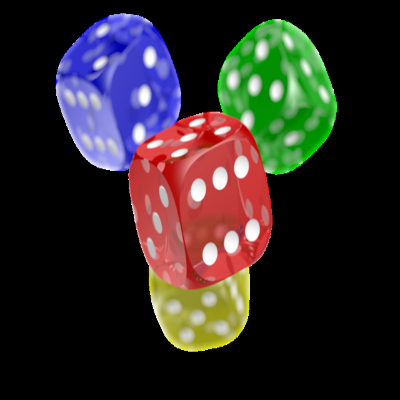

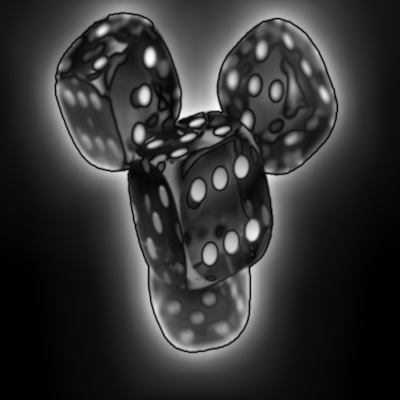

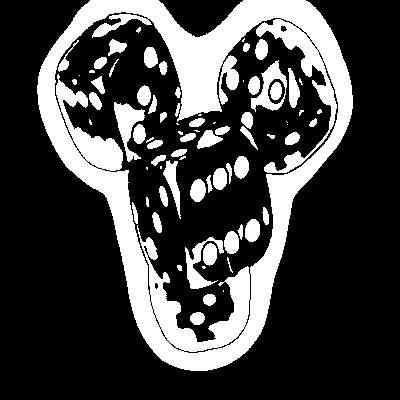

In [ ]:
!pip install opencv-contrib-python
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/640px-PNG_transparency_demonstration_1.png'
urllib.request.urlretrieve(url, 'image.png')

image = cv2.imread('image.png')
image = cv2.resize(image, (400, 400))

saliency = cv2.saliency.StaticSaliencyFineGrained_create()
(success, saliency_map) = saliency.computeSaliency(image)

threshMap = cv2.threshold((saliency_map * 255).astype("uint8"), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

cv2_imshow(image)
cv2_imshow((saliency_map * 255).astype("uint8"))
cv2_imshow(threshMap)


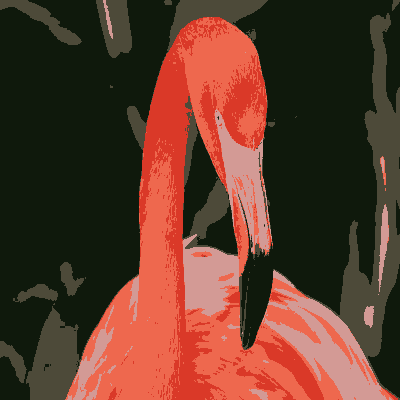

In [ ]:
import cv2
import numpy as np
import urllib.request
from google.colab.patches import cv2_imshow

url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Phoenicopterus_ruber_in_S%C3%A3o_Paulo_Zoo.jpg/640px-Phoenicopterus_ruber_in_S%C3%A3o_Paulo_Zoo.jpg'
urllib.request.urlretrieve(url, 'landscape.jpg')

img = cv2.imread('landscape.jpg')
img = cv2.resize(img, (400, 400))

Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 5
ret, label, center = cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

center = np.uint8(center)
res = center[label.flatten()]
segmented_image = res.reshape((img.shape))

cv2_imshow(segmented_image)

In [ ]:
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


<IPython.core.display.Javascript object>

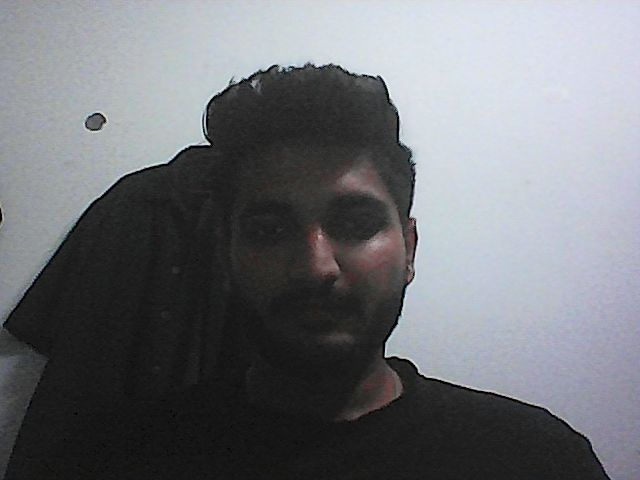

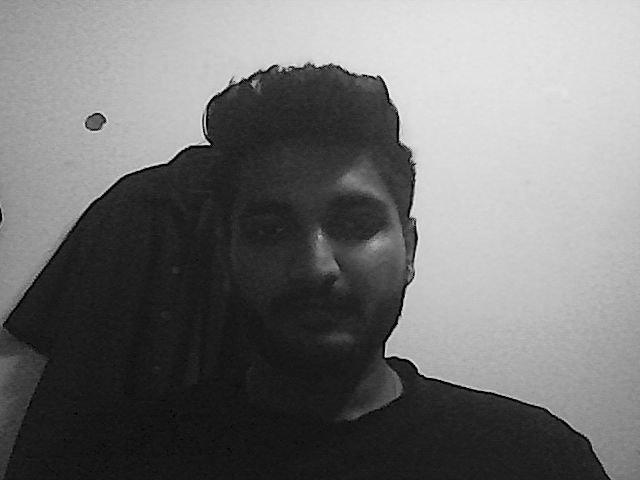

Motion Detection Result:


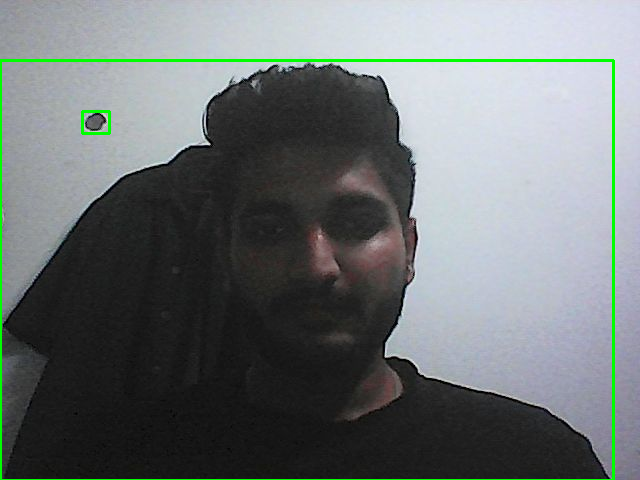

Detected Text (OCR):
 


In [ ]:
!pip install opencv-python pytesseract
!sudo apt install tesseract-ocr -y

from IPython.display import display, Javascript
from google.colab.output import eval_js
from IPython.display import Image
import cv2
import PIL.Image
import io
import numpy as np
import base64
import pytesseract

from google.colab.patches import cv2_imshow

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();

          const dataUrl = canvas.toDataURL('image/jpeg', quality);
          return dataUrl;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    with open(filename, 'wb') as f:
        f.write(binary.getbuffer())
    img = cv2.imdecode(np.frombuffer(binary.getbuffer(), np.uint8), cv2.IMREAD_COLOR)
    return img

img = take_photo()
cv2_imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

background = cv2.GaussianBlur(gray, (21, 21), 0)
diff = cv2.absdiff(gray, background)
_, thresh = cv2.threshold(diff, 25, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

motion_img = img.copy()
for cnt in contours:
    if cv2.contourArea(cnt) > 300:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(motion_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

print("Motion Detection Result:")
cv2_imshow(motion_img)

text = pytesseract.image_to_string(gray)
print("Detected Text (OCR):\n", text.strip())

In [ ]:
!pip install -q imageio imageio-ffmpeg
!pip install -q git+https://github.com/bogireddytejareddy/gan-video-generation.git
!apt-get install unrar

import os
import random
import shutil
import cv2
import numpy as np
import imageio
from glob import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm

!wget --no-check-certificate http://crcv.ucf.edu/data/UCF101/UCF101.rar

!mkdir ucf101_videos
!unrar x UCF101.rar ucf101_videos/

print("✅ UCF101 dataset downloaded and extracted.")

selected_classes = ['JumpingJack', 'PushUps']
n_videos_per_class = 5
resize_height = 64
resize_width = 64
target_frames = 16

dataset_root = 'ucf101_videos/UCF-101'
processed_root = 'processed_videos'

os.makedirs(processed_root, exist_ok=True)

for cls in selected_classes:
    class_path = os.path.join(dataset_root, cls)
    save_class_path = os.path.join(processed_root, cls)
    os.makedirs(save_class_path, exist_ok=True)

    videos = glob(os.path.join(class_path, '*.avi'))
    selected_videos = random.sample(videos, n_videos_per_class)

    for idx, video_path in enumerate(selected_videos):
        cap = cv2.VideoCapture(video_path)
        frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (resize_width, resize_height))
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()

        if len(frames) >= target_frames:
            frames = frames[:target_frames]
        else:
            frames = frames + [frames[-1]] * (target_frames - len(frames))

        frames = np.array(frames)
        np.save(os.path.join(save_class_path, f'{cls}_{idx}.npy'), frames)

print("✅ Videos processed and saved.")

Streaming output truncated to the last 5000 lines.
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingGuitar_g08_c01.avi      62%  OK 
Extracting  ucf101_videos/UCF-101/PlayingGuitar/v_PlayingG

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from glob import glob
from tqdm import tqdm
import imageio

class VideoDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.files = []
        for cls in os.listdir(root_dir):
            cls_folder = os.path.join(root_dir, cls)
            self.files.extend(glob(os.path.join(cls_folder, '*.npy')))
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        video = np.load(self.files[idx])
        video = video.astype(np.float32) / 127.5 - 1.0
        video = torch.from_numpy(video).permute(3, 0, 1, 2)
        return video

processed_root = '/content/processed_videos'
dataset = VideoDataset(processed_root)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(100, 512*2*4*4)
        self.deconv = nn.Sequential(
            nn.ConvTranspose3d(512, 256, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 3, (2,4,4), stride=(2,2,2), padding=(0,1,1)),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 512, 2, 4, 4)
        return self.deconv(x)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(64, 128, 4, 2, 1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(128, 256, 4, 2, 1),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv3d(256, 1, (2,4,4), stride=1, padding=0),
        )

    def forward(self, x):
        return self.conv(x).view(x.size(0), -1)


G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 50

for epoch in range(epochs):
    G.train()
    D.train()
    g_running_loss = 0.0
    d_running_loss = 0.0

    for real_videos in tqdm(dataloader):
        real_videos = real_videos.to(device)

        batch_size = real_videos.size(0)

        optimizer_G.zero_grad()
        z = torch.randn(batch_size, 100, device=device)
        fake_videos = G(z)

        pred_fake = D(fake_videos)
        valid = torch.ones_like(pred_fake, device=device)

        g_loss = criterion(pred_fake, valid)
        g_loss.backward()
        optimizer_G.step()

        optimizer_D.zero_grad()
        pred_real = D(real_videos)
        pred_fake = D(fake_videos.detach())

        valid = torch.ones_like(pred_real, device=device)
        fake = torch.zeros_like(pred_fake, device=device)

        real_loss = criterion(pred_real, valid)
        fake_loss = criterion(pred_fake, fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        g_running_loss += g_loss.item()
        d_running_loss += d_loss.item()

    avg_g_loss = g_running_loss / len(dataloader)
    avg_d_loss = d_running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {avg_d_loss:.4f}  G_loss: {avg_g_loss:.4f}")

G.eval()
z = torch.randn(1, 100, device=device)
fake_video = G(z).detach().cpu()
fake_video = (fake_video + 1) / 2
fake_video = fake_video.squeeze().permute(1, 2, 3, 0).numpy()

frames = [(frame*255).astype(np.uint8) for frame in fake_video]
imageio.mimsave('generated_video.gif', frames, fps=4)

print("✅ Generated video saved as 'generated_video.gif'.")

100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch [1/50]  D_loss: 0.3449  G_loss: 2.0689


100%|██████████| 3/3 [00:06<00:00,  2.01s/it]


Epoch [2/50]  D_loss: 0.0570  G_loss: 2.8948


100%|██████████| 3/3 [00:06<00:00,  2.28s/it]


Epoch [3/50]  D_loss: 0.0376  G_loss: 3.9745


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch [4/50]  D_loss: 0.0265  G_loss: 4.2722


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Epoch [5/50]  D_loss: 0.0307  G_loss: 5.7915


100%|██████████| 3/3 [00:03<00:00,  1.23s/it]


Epoch [6/50]  D_loss: 0.0228  G_loss: 7.5927


100%|██████████| 3/3 [00:03<00:00,  1.15s/it]


Epoch [7/50]  D_loss: 0.0532  G_loss: 9.4397


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [8/50]  D_loss: 0.0096  G_loss: 13.0459


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [9/50]  D_loss: 0.0100  G_loss: 6.1661


100%|██████████| 3/3 [00:03<00:00,  1.26s/it]


Epoch [10/50]  D_loss: 0.0079  G_loss: 6.0213


100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch [11/50]  D_loss: 0.0071  G_loss: 5.7331


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [12/50]  D_loss: 0.0071  G_loss: 6.7568


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [13/50]  D_loss: 0.0098  G_loss: 6.2388


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


Epoch [14/50]  D_loss: 0.0069  G_loss: 7.4943


100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch [15/50]  D_loss: 0.0083  G_loss: 6.9066


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [16/50]  D_loss: 0.0057  G_loss: 9.4826


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [17/50]  D_loss: 0.1075  G_loss: 11.7845


100%|██████████| 3/3 [00:03<00:00,  1.31s/it]


Epoch [18/50]  D_loss: 0.0028  G_loss: 15.8433


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [19/50]  D_loss: 0.0012  G_loss: 15.1614


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [20/50]  D_loss: 0.0011  G_loss: 14.2512


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [21/50]  D_loss: 0.0009  G_loss: 10.2547


100%|██████████| 3/3 [00:03<00:00,  1.29s/it]


Epoch [22/50]  D_loss: 0.0075  G_loss: 5.0059


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [23/50]  D_loss: 0.0037  G_loss: 6.4489


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [24/50]  D_loss: 0.0058  G_loss: 6.9614


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [25/50]  D_loss: 0.0045  G_loss: 6.4547


100%|██████████| 3/3 [00:04<00:00,  1.33s/it]


Epoch [26/50]  D_loss: 0.0059  G_loss: 6.4781


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [27/50]  D_loss: 0.0056  G_loss: 5.7310


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [28/50]  D_loss: 0.0098  G_loss: 8.8403


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [29/50]  D_loss: 0.0044  G_loss: 11.4569


100%|██████████| 3/3 [00:04<00:00,  1.34s/it]


Epoch [30/50]  D_loss: 0.0020  G_loss: 8.0930


100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch [31/50]  D_loss: 0.0044  G_loss: 5.8366


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [32/50]  D_loss: 0.0022  G_loss: 8.0313


100%|██████████| 3/3 [00:04<00:00,  1.47s/it]


Epoch [33/50]  D_loss: 0.0066  G_loss: 7.3169


100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Epoch [34/50]  D_loss: 0.0038  G_loss: 9.6326


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Epoch [35/50]  D_loss: 0.0055  G_loss: 6.0510


100%|██████████| 3/3 [00:02<00:00,  1.00it/s]


Epoch [36/50]  D_loss: 0.0030  G_loss: 9.7071


100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch [37/50]  D_loss: 0.0031  G_loss: 7.0352


100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


Epoch [38/50]  D_loss: 0.0227  G_loss: 11.3501


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [39/50]  D_loss: 0.0024  G_loss: 14.6677


100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


Epoch [40/50]  D_loss: 0.0010  G_loss: 11.0254


100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch [41/50]  D_loss: 0.0015  G_loss: 7.2299


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch [42/50]  D_loss: 0.0041  G_loss: 6.2463


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [43/50]  D_loss: 0.0019  G_loss: 7.2382


100%|██████████| 3/3 [00:03<00:00,  1.02s/it]


Epoch [44/50]  D_loss: 0.0041  G_loss: 6.3290


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [45/50]  D_loss: 0.0023  G_loss: 6.9705


100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Epoch [46/50]  D_loss: 0.0065  G_loss: 7.2419


100%|██████████| 3/3 [00:03<00:00,  1.00s/it]


Epoch [47/50]  D_loss: 0.0025  G_loss: 6.5993


100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Epoch [48/50]  D_loss: 0.0023  G_loss: 6.9724


100%|██████████| 3/3 [00:03<00:00,  1.14s/it]


Epoch [49/50]  D_loss: 0.0029  G_loss: 6.1650


100%|██████████| 3/3 [00:03<00:00,  1.20s/it]


Epoch [50/50]  D_loss: 0.0033  G_loss: 6.8948
✅ Generated video saved as 'generated_video.gif'.


In [9]:
import zipfile
import os

zip_path = '/content/archive.zip'
extract_path = 'fer_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted folders:", os.listdir(extract_path))

Extracted folders: ['images']


In [10]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

data_path = "/content/fer_dataset/images/images/train"
emotions = ['neutral', 'happy', 'surprise', 'sad', 'angry', 'disgust', 'fear']
emotion_dict = {e: i for i, e in enumerate(emotions)}

def load_data():
    data, labels = [], []
    for emotion in emotions:
        folder = os.path.join(data_path, emotion)
        for file in os.listdir(folder):
            img_path = os.path.join(folder, file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            data.append(img)
            labels.append(emotion_dict[emotion])
    return np.array(data), np.array(labels)

X, y = load_data()
X = X.reshape(-1, 48, 48, 1) / 255.0
y = to_categorical(y, num_classes=len(emotions))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(len(emotions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test))
model.save("emotion_model.h5")


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,847 (1.36 MB)

 Trainable params: 355,847 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 90s 121ms/step - accuracy: 0.2614 - loss: 1.7926 - val_accuracy: 0.4172 - val_loss: 1.5306
Epoch 2/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 94s 130ms/step - accuracy: 0.4116 - loss: 1.5206 - val_accuracy: 0.4748 - val_loss: 1.4072
Epoch 3/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 138s 125ms/step - accuracy: 0.4557 - loss: 1.4144 - val_accuracy: 0.5013 - val_loss: 1.3295
Epoch 4/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 86s 119ms/step - accuracy: 0.4896 - loss: 1.3218 - val_accuracy: 0.5011 - val_loss: 1.3077
Epoch 5/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 142s 118ms/step - accuracy: 0.5110 - loss: 1.2647 - val_accuracy: 0.5204 - val_loss: 1.2542
Epoch 6/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 148s 127ms/step - accuracy: 0.5251 - loss: 1.2406 - val_accuracy: 0.5336 - val_loss: 1.2303
Epoch 7/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 87s 121ms/step - accuracy: 0.5320 - loss: 1.2116 - val_accuracy: 0.5324 - val_loss: 1.2380
Epoch 8/15
721/721 ━━━━━━━━━━━━━━━━━━━━ 86s 119ms/step - accuracy: 0.5515 - loss

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


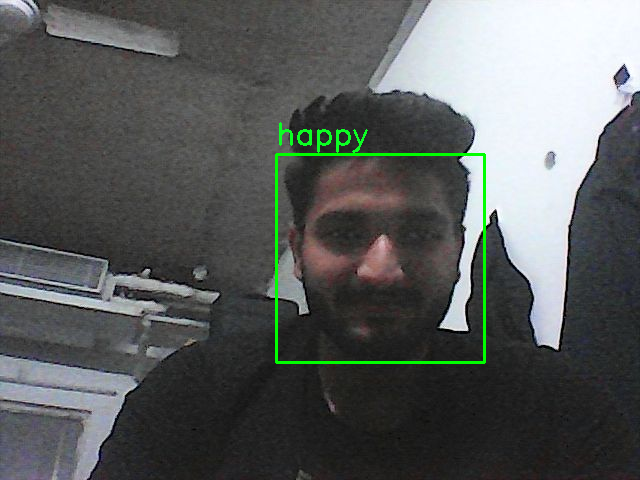

In [14]:
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import io, base64

model = load_model("emotion_model.h5")

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
          const div = document.createElement('div');
          const capture = document.createElement('button');
          capture.textContent = 'Capture';
          div.appendChild(capture);

          const video = document.createElement('video');
          video.style.display = 'block';
          const stream = await navigator.mediaDevices.getUserMedia({video: true});

          document.body.appendChild(div);
          div.appendChild(video);
          video.srcObject = stream;
          await video.play();

          google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
          await new Promise((resolve) => capture.onclick = resolve);

          const canvas = document.createElement('canvas');
          canvas.width = video.videoWidth;
          canvas.height = video.videoHeight;
          canvas.getContext('2d').drawImage(video, 0, 0);
          stream.getVideoTracks()[0].stop();
          div.remove();

          const dataUrl = canvas.toDataURL('image/jpeg', quality);
          return dataUrl;
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    return cv2.imdecode(np.frombuffer(binary.getbuffer(), np.uint8), cv2.IMREAD_COLOR)

img = take_photo()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml").detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    roi = gray[y:y+h, x:x+w]
    roi = cv2.resize(roi, (48, 48)).reshape(1, 48, 48, 1) / 255.0
    pred = model.predict(roi)
    emotion = emotions[np.argmax(pred)]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (36,255,12), 2)

cv2_imshow(img)